In [55]:
from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
# Create mesh and define function space

nx, ny = 20, 40
mesh   = RectangleMesh(Point(0, 0), Point(2, 4), nx, ny)

Qe      = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Be      = FiniteElement("Bubble",   mesh.ufl_cell(), 4)
Ve      = VectorElement(NodalEnrichedElement(Qe, Be))
element = MixedElement(Ve,Qe)
W       = FunctionSpace(mesh, element)

# Define trial and test functions
w       = Function(W)
(u, p)  = TrialFunctions(W)
(v, q)  = TestFunctions(W)
n       = FacetNormal(mesh)

In [56]:
#Defining subdomains
def walls(x, on_boundary):
    return near(x[0],0) or near(x[0], 2) or \
           near(x[1],0) or near(x[1], 4) and on_boundary          # Wall contour

def b_inj(x):
    tol=1E-15
    return (abs(x[0]) < tol) and (abs(x[1] - 1)  < tol)   # Injection coordinates  (1,1)

def b_out(x):
    tol=1E-15
    return (abs(x[0] - 1) < tol) and (abs(x[1] - 3) < tol)    # Outflow coordinates    (1,3) 

def b_right(x, on_boundary):
    return near(x[0],1) and on_boundary                           # right boundary (2,0)

def b_left(x, on_boundary):
    return near(x[0],0) and on_boundary                           # left boundary (0,0)

class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return near(x[1],0) and on_boundary

class Top(SubDomain):
    def inside(self,x, on_boundary):
        return near(x[1],4) and on_boundary
    
### SUB-DOMAINS ###

bottom = Bottom()
top    = Top()

sub_domains = MeshFunction('size_t', mesh, 1)
sub_domains.set_all(0)

bottom.mark(sub_domains, 1)
top.mark(sub_domains, 2)

In [57]:
# Construct a spatially-varying permeability matrix (inverse)#
#k = "1.0/(exp(-(((x[1] - 1.5 - 0.1*sin(10*x[0]))/0.1)*((x[1] - 1.5 - 0.1*sin(10*x[0]))/0.1))) + 1.0)"
k = "1.0"
k11 = Expression(k, degree = 2)
k12 = Constant(0.0)
k21 = Constant(0.0)
k22 = Expression(k, degree = 2)
K = as_matrix(((k11, k12), (k21, k22)))


ds = Measure('ds', domain=mesh, subdomain_data=sub_domains)

a =  (dot(K*u,v) - div(v)*p - div(u)*q)*dx
L = Constant(1)*dot(n,v)*ds     #(1)  + Constant(2)*dot(n,v)*ds(2)# f*dot(n,v)*ds



In [61]:
# W.sub(0) - Векторное поле скоростей u;
# W.sub(1) - Скалярное поле давления p

bc_n     = DirichletBC(W.sub(0), Constant ((0,0)), walls)                       # Neumann on the walls 
# bc_d     = DirichletBC(W.sub(1), Constant (0),   walls)  
bc_in    = DirichletBC(W.sub(1), Constant (1),     b_inj, method='pointwise')   # Dirichlet (p=1) on injection point (1,1)
bc_out   = DirichletBC(W.sub(1), Constant (0),     b_out, method='pointwise')   # Dirichlet (p=0) on out point (1,3)
bc_left  = DirichletBC(W.sub(1), Constant (1),     b_left)                      # Dirichlet (p=0) on left boundary
bc_right = DirichletBC(W.sub(1), Constant (0),     b_right)                     # Dirichlet (p=0) on right boundary

Solving linear variational problem.


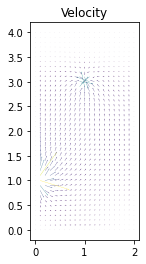

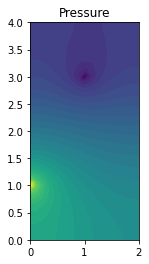

In [62]:
solve(a == L, w, bcs = [bc_n, bc_in, bc_out])
(u, p) = w.split()

file = File("flow.pvd")
file << w.split()[0]
plot(u, title = 'Velocity')
plt.show()
# plt.savefig('U.png')

# file = File("pressure.pvd")
# file << w.split()[1]
plot(p, title = 'Pressure')
plt.show()
#plt.savefig('P.png')

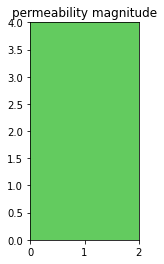

In [63]:
plot(k11, title="permeability magnitude", mesh=mesh)

coor     = mesh.coordinates()             # np.array (861, 2); all coordinates

B        = np.where(coor[:,1]==[2])   # nodes satisfying y = 2
p_values = p.compute_vertex_values()  # All values 

p_v      = p_values[B]                # Values satisfying B
x_m      = coor[B, 0]                 # x coordinates if y = 2

x        = np.arange(0,2.1,0.1)       #  
p_an     = 1 - x/2                    # Analytic solution of the equation

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=p_an,
    name='Analytic solution',))

fig.add_trace(go.Scatter(
    x=x,
    y=p_v,
    name='fenics solution',))

fig.show()
fig.write_image("p_compare.png")